# Data visualisation extended abstract code

## Loading in packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from windrose import WindroseAxes
import matplotlib.cm as cm
import pandas as pd

## Setting up the topography data

The following code is used to import and configure the topography data

In [2]:
#configuring data from .tif to be read in py
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray())
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx, maxx, width)
    lat = np.linspace(miny, maxy, height)
    return lon, lat, z

In [3]:
dataset = gdal.Open(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\QGIS\Topography\alos_mkgdi.tif')

# Extract data using the xyz_geotiff function
lon_geotiff, lat_geotiff, z_geotiff = xyz_geotiff(dataset)

C:\ProgramData\miniconda3\envs\inst312\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Setting up the wind data
The following code is to set up the wind data, calculate wind speed and wind direction and make it readable for the windrose's directional set up

In [4]:
#Function below is to fix the angles to go between zero and 360
def convert_to_compass(angle): 
    return (-angle+90)%360

#The longitude and latitude selected below are just the approximate center of the topography map above
data = xr.open_dataset(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\QGIS\Topography\makgadikgadi_u10_v10_2001-2020.nc')
data1 = data.sel(longitude=25.0,latitude=-20.5)

In [5]:
#importing the data and calculating wind direction (wd) and wind speed (ws)
data1['wd'] = np.arctan2(-data1.v10,-data1.u10)*180/np.pi
data1['ws'] = (data1.v10**2+data1.u10**2)**0.5
data1['compass'] = convert_to_compass(data1.wd)
data1

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 175320)
Coordinates:
    longitude  float32 4B 25.0
    latitude   float32 4B -20.5
  * time       (time) datetime64[ns] 1MB 2001-01-01 ... 2020-12-31T23:00:00
Data variables:
    u10        (time) float32 701kB 1.148 0.9781 0.3345 ... -2.785 -2.934 -2.708
    v10        (time) float32 701kB -2.768 -3.03 -4.007 ... -4.288 -4.203 -3.782
    wd         (time) float32 701kB 112.5 107.9 94.77 91.1 ... 57.0 55.09 54.4
    ws         (time) float32 701kB 2.997 3.184 4.02 4.383 ... 5.113 5.126 4.652
    compass    (time) float32 701kB 337.5 342.1 355.2 358.9 ... 33.0 34.91 35.6
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-09 19:16:53 UTC+1100 by era5_replication_tools-1.8....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 land 10m_u_component_of_wind 20010101-20010131

## Plotting it all up!

Starting off with separate plots of the topog and and the windrose

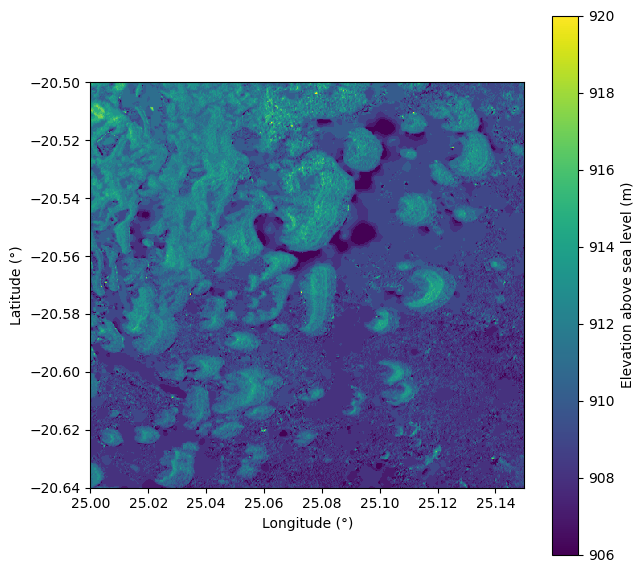

In [6]:
#"zoomed out" topography plot
plt.figure(figsize=(7, 7))
plt.pcolormesh(lon_geotiff, lat_geotiff, z_geotiff, shading='auto', vmin= 906, vmax= 920)
plt.axis('square')
plt.colorbar(label='Elevation above sea level (m)')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim([-20.64,-20.5])
plt.xlim([25.0, 25.15])
#plt.savefig(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\extended_abs\zoomed_out_final', dpi = 300)
plt.show()

MemoryError: Unable to allocate 316. MiB for an array with shape (5189, 7993) and data type float64

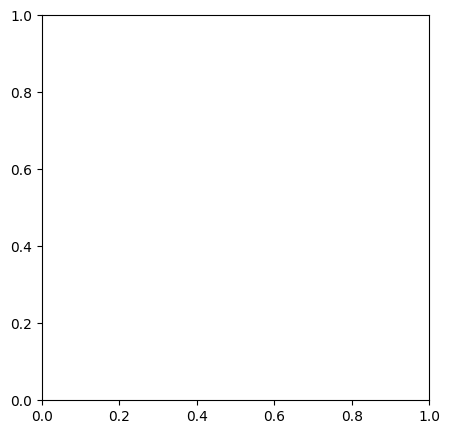

In [29]:
#"zoomed in" topog plot of single mound feature
plt.figure(figsize=(5,5))
plt.pcolormesh(lon_geotiff, lat_geotiff, z_geotiff, shading='auto', vmin= 906, vmax= 918)
plt.axis('square')
plt.colorbar(label='Elevation above sea level (m)', location = 'bottom')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim([-20.58382213,-20.55924])
plt.xlim([25.101, 25.1297])
#plt.savefig(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\extended_abs\zoomed_in_final')

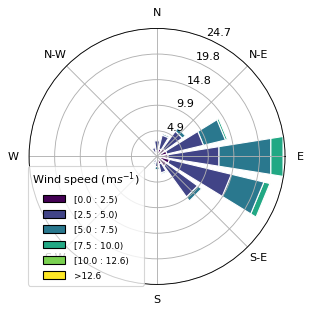

In [10]:
#windrose
ax = WindroseAxes.from_ax(figsize = (4,4))
ax.bar(data1.compass, data1.ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title = 'Wind speed (m$s^{-1}$)')
#plt.savefig(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\extended_abs\windrose_final', dpi = 300)

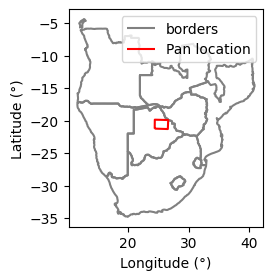

In [28]:
#Making a contextual map
#maybe build it up from the axes next time to manipulate everything
import geopandas as gpd

borders = gpd.read_file(r'C:\Users\lelob\Documents\Useful GIS\Africa boundaries\southern.shp')
boundary = gpd.read_file(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\QGIS\Topography\Mkgdi_bounds.shp')

#plotting 2 vectors on each other, using a separate axes (from subplot)
plt.figure(figsize = (3,3))
ax = plt.subplot(111)
base = borders.boundary.plot(ax=ax,color = 'grey', label="borders")
box = boundary.boundary.plot(ax=ax, color = 'red', label = "Pan location")
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.subplots_adjust(top=0.925, bottom=0.20, left=0.15, right=0.97, hspace=0.01, wspace=0.01)
plt.legend()
plt.savefig(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\extended_abs\context_final', dpi = 300)

# Making the sediment flux rose
First bit of code is the calculations for the flux at different thresholds, then finding the net resultants. Constructing the roses is after that

In [28]:
#loading in data again and packages
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from windrose import WindroseAxes
import matplotlib.cm as cm
import pandas as pd

# friction velocity function definition

def shear_vel(wind_speed):
    k = 0.4
    z = 10
    r_zero = 10**-2
    u_star = k * wind_speed/np.log(z/r_zero)
    return u_star

data1['u_star'] = shear_vel(data1['ws'])
data1    

<xarray.Dataset> Size: 6MB
Dimensions:    (time: 175320)
Coordinates:
    longitude  float32 4B 25.0
    latitude   float32 4B -20.5
  * time       (time) datetime64[ns] 1MB 2001-01-01 ... 2020-12-31T23:00:00
Data variables:
    u10        (time) float32 701kB 1.148 0.9781 0.3345 ... -2.785 -2.934 -2.708
    v10        (time) float32 701kB -2.768 -3.03 -4.007 ... -4.288 -4.203 -3.782
    wd         (time) float32 701kB 112.5 107.9 94.77 91.1 ... 57.0 55.09 54.4
    ws         (time) float32 701kB 2.997 3.184 4.02 4.383 ... 5.113 5.126 4.652
    compass    (time) float32 701kB 337.5 342.1 355.2 358.9 ... 33.0 34.91 35.6
    u_star     (time) float32 701kB 0.1735 0.1844 0.2328 ... 0.2968 0.2694
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-09 19:16:53 UTC+1100 by era5_replication_tools-1.8....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 land 10m_u_component_of_wind 20010101-20010131

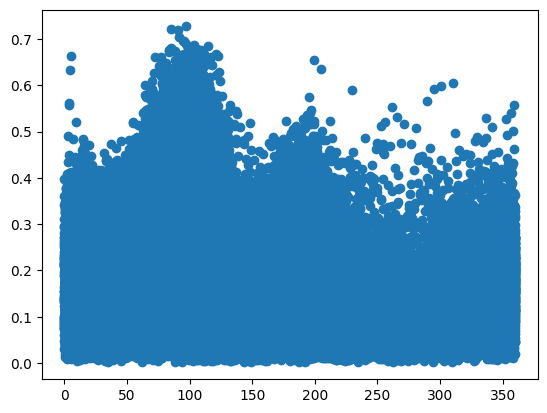

In [29]:
plt.scatter(data1.compass, data1.u_star)

In [30]:
#filtering out u_star values with different thresholds, replacing values which do not meet the conditions with "0"
#thresholds were chosen arbitrarily
data1['thresh_5'] = data1.u_star.where(data1.u_star> 0.5, 0)
data1['thresh_4'] = data1.u_star.where(data1.u_star> 0.4, 0)
data1['thresh_3'] = data1.u_star.where(data1.u_star> 0.3, 0)

#checking what new data looks like

In [31]:
#creating the saltation flux 
#using kg/m^3 for densities, need to double check all units

def sal_flux(threshold, winds):
    Cq= 5
    pf = 1.225
    pd = 2.65
    g = 9.8
    Q = Cq*(threshold/g)*(pf/pd)*(winds**2-threshold**2)
    return(Q)

#creating saltation flux columns for each threshold at each time step, filtering out negative values (need to find more efficient way to do this)
data1['q5'] = data1.thresh_5.where((sal_flux(0.5, data1.thresh_5)) > 0, 0)
data1['q4'] = data1.thresh_4.where((sal_flux(0.4, data1.thresh_4)) > 0, 0)
data1['q3'] = data1.thresh_3.where((sal_flux(0.3, data1.thresh_3)) > 0, 0)

In [32]:
#dealing with directions? The following code was sent by Dom
# OPTION 1
#may need to change nans to zeros
# 1a
#nqm = np.abs(np.sum(qm*(np.exp(1j*qa))))
nqa3 = np.angle(np.sum(data1.q3*(np.exp(1j*(data1.wd*(np.pi/180))))))
nqa4 = np.angle(np.sum(data1.q4*(np.exp(1j*(data1.wd*(np.pi/180))))))
nqa5 = np.angle(np.sum(data1.q5*(np.exp(1j*(data1.wd*(np.pi/180))))))
# 1b
#nqm = (np.sum(qm*np.cos(qa))**2+np.sum(qm*np.sin(qa))**2)**0.5
#nqa = np.arctan2(np.sum(qm*np.sin(qa)),np.sum(qm*np.cos(qa)))

# OPTION 2
#nqx = np.sum(qm*np.cos(qa))
#nqy = np.sum(qm*np.sin(qa))
nqa4 #this is the net resultant angle
#here is the sum of the magnitudes
nrm3 = np.sum(data1.q3)
nrm4 = np.sum(data1.q4)
nrm5 = np.sum(data1.q5)

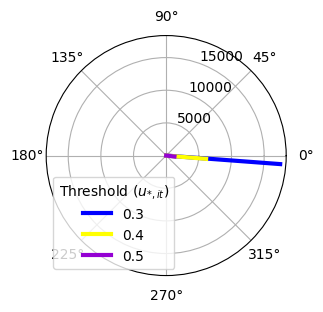

In [86]:
#plotting these resultants
fig = plt.figure(figsize = (3,3))
ax = fig.add_axes([0,0,0.8,0.8],projection = 'polar')
plt.plot([nqa3,nqa3], [0,nrm3], 'blue'      , lw = 3, label = "0.3")
plt.plot([nqa4,nqa4], [0,nrm4], 'yellow',     lw = 3, label = "0.4")
plt.plot([nqa5,nqa5], [0,nrm5], 'darkviolet', lw=  3, label = "0.5")
ax.set_rticks([5000, 10000, 15000])
ax.set_rlabel_position(70)
ax.legend(title = 'Threshold ($u_{*,it}$)', loc = 'lower left')
#plt.savefig(r'C:\Users\lelob\Documents\Monash_Coursework\Masters\Sem_1_2024\extended_abs\salt_flux_final')

## Plotting the flux roses

In [34]:
#Calculating the net sand flux, using the sum of the magnitudes, and retrieving its angle
